In [95]:
# Importing libraries
import numpy as np
import pandas as pd
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.draw import line
from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage.filters import sobel
from skimage import exposure
from skimage.restoration import denoise_bilateral
from skimage.feature import canny
from skimage import color
from skimage.feature import ORB, SIFT, BRIEF
from skimage.feature import match_descriptors
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches)
from skimage.measure import ransac
from skimage.registration import phase_cross_correlation
from skimage.transform import EuclideanTransform
from skimage.transform import SimilarityTransform
from skimage.transform import warp, AffineTransform, rotate, resize
from skimage.morphology import binary_dilation, binary_erosion
from __future__ import print_function
import cv2
from PIL import Image, ImageFilter
from transformers import AutoFeatureExtractor, ResNetForImageClassification
import torch
from datasets import load_dataset
from io import BytesIO   

In [96]:
def binarize_image(img):
    thresh = threshold_otsu(img)
    binary = img > thresh
    binary = exposure.equalize_adapthist(binary, clip_limit=0.03)
    return binary

# display the image
def show_image(image, title='Image', cmap_type='gray'):
    plt.figure(figsize = (10, 15))
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

# binarize and enhance the image    
def preprocess(image_list, rescale=False, binarize=True,
              new_scan=True, exemplar=False):
    return_list = []
    for img in image_list:
        if new_scan:
            # crop the hand writing and denoise
            ydim, xdim = img.shape
            box_width = 900
            box_height = 600
            if exemplar:
                img = img.astype(bool)
                img[:,:300] = colorize_image(img[:,:300],[255,255,255])[:,:,1]
                img[:,xdim-300:xdim] = colorize_image(img[:,xdim-300:xdim],[255,255,255])[:,:,1]
                pic_grayscale_cropped = img.astype(int)
            else:
                img[ydim-box_height:ydim,xdim-box_width:xdim] = colorize_image(img[ydim-box_height:ydim, 
                                                                                              xdim-box_width:xdim],
                                                                  [255,255,255])[:,:,1]
                pic_grayscale_cropped = img[:,100:xdim].astype(int)
        else:
            pic_grayscale = color.rgb2gray(img)
            ruler_length = 159
            ydim, xdim = pic_grayscale.shape[0], pic_grayscale.shape[1]
            pic_grayscale_cropped = pic_grayscale[ruler_length:ydim-ruler_length, 
                                                  ruler_length:xdim-ruler_length]
        if rescale:
            height = ydim/2
            width = xdim/2
            pic_grayscale_cropped = resize(pic_grayscale_cropped, 
                                   (height, width), 
                                   anti_aliasing=True)
        if binarize:
            binary = binarize_image(pic_grayscale_cropped)
        else:
            binary = pic_grayscale_cropped
        return_list.append(binary)
    return return_list

# save the image
def save_image(img, name):
    I = img
    I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)

    img = Image.fromarray(I8)
    img.save(name)
    
# color the pixels
def colorize_image(img, color_code):
    if len(img.shape) == 2:
        img = color.gray2rgb(img)
    height, width, _ = img.shape
    for i in range(height):
        for j in range(width):
            if img[i, j, 0] < 0.5:
                img[i, j] = color_code
            else:
                img[i, j] = [255,255,255]
    return img

In [102]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension


(4950, 2300)

In [88]:
from ipywidgets import FloatProgress
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

In [90]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [133]:
# Load the pretrained model
model = models.resnet34(pretrained=True)
# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/davidchu/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████████| 83.3M/83.3M [00:06<00:00, 13.3MB/s]


In [134]:
# Set model to evaluation mode
model.eval()
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vector(image_name):
    # 1. Load the image with Pillow library
    img = Image.open(image_name).convert("RGB")
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data.reshape(o.data.size(1)))
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding

In [286]:
no_weight_vector = get_vector("no_weight/03.png")
max_weight_vector = get_vector("max_weight/03.png")

In [138]:
# Using PyTorch Cosine Similarity
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
cos_sim = cos(no_weight_vector.unsqueeze(0),
              max_weight_vector.unsqueeze(0))
print('\nCosine similarity: {0}\n'.format(cos_sim))


Cosine similarity: tensor([0.9451])



In [391]:
# Apply for multiple images
import glob
noweight_images = []
noweight_features_vec = []
for filename in glob.glob('no_weight/*.png'):
    print(filename)
    noweight_images.append(np.array(Image.open(filename)))
    resnet_vec = np.array(get_vector(filename))
    noweight_features_vec.append(resnet_vec)

maxweight_images = []
maxweight_features_vec = []
for filename in glob.glob('max_weight/*.png'):
    print(filename)
    maxweight_images.append(np.array(Image.open(filename)))
    resnet_vec = np.array(get_vector(filename))
    maxweight_features_vec.append(resnet_vec)

no_weight/14.png
no_weight/01.png
no_weight/15.png
no_weight/03.png
no_weight/17.png
no_weight/16.png
no_weight/02.png
no_weight/12.png
no_weight/13.png
no_weight/11.png
no_weight/05.png
no_weight/04.png
no_weight/10.png
no_weight/09.png
no_weight/20.png
no_weight/18.png
no_weight/19.png
max_weight/14.png
max_weight/01.png
max_weight/15.png
max_weight/03.png
max_weight/17.png
max_weight/16.png
max_weight/02.png
max_weight/12.png
max_weight/13.png
max_weight/11.png
max_weight/05.png
max_weight/04.png
max_weight/10.png
max_weight/09.png
max_weight/20.png
max_weight/18.png
max_weight/19.png


In [399]:
from sklearn.decomposition import PCA
pca_1 = PCA(n_components=1)
noweight_features_reduced = pca_1.fit_transform(noweight_features_vec)
pca_2 = PCA(n_components=1)
maxweight_features_reduced = pca_2.fit_transform(maxweight_features_vec)

In [400]:
pca_2.explained_variance_ratio_.sum()

0.20079850684014008

In [401]:
pca_1.explained_variance_ratio_.sum()

0.22887704510850043

In [405]:
df1 = pd.DataFrame(noweight_features_reduced)

In [406]:
df2 = pd.DataFrame(maxweight_features_reduced)

In [394]:
pd.DataFrame(noweight_features_reduced).to_csv('no_weight.csv', index=False)
pd.DataFrame(maxweight_features_reduced).to_csv('max_weight.csv', index=False)

In [413]:
# Conduct paired t-test
from scipy import stats
for colname in df1:
    print(stats.ttest_rel(df1[colname].values, df2[colname].values))

Ttest_relResult(statistic=-3.0752886792076166e-15, pvalue=0.9999999999999976)


In [ ]:
### ====== NOT USED ======== ###

In [238]:
# Get the pixel density difference
def get_pixel_diff(img1, img2):
    thresh1 = threshold_otsu(img1)
    thresh2 = threshold_otsu(img2)
    img1 = img1.flatten()
    img2 = img2.flatten()
    avg_density_diff = np.mean(img1) - np.mean(img2) 
    black_pixel_count_diff = np.count_nonzero(img2 < thresh2) - np.count_nonzero(img1 < thresh1)
    return [avg_density_diff, black_pixel_count_diff]

def get_misaligned_pixels(img1, img2, thresh1, thresh2):
    img1 = img1 > thresh1
    img2 = img2 > thresh2
    count = 0
    x_bound, y_bound = img1.shape[1], img1.shape[0]
    for i in range(y_bound):
        for j in range(x_bound):
            if img1[i,j] ^ img2[i,j]:
                count += 1
    return count


In [239]:
img2 = np.array(Image.open('resnet_test/Shoe01R-2-150.0-M2-transformed.png'))
img1 = np.array(Image.open('resnet_test/Shoe01R-2-211.4-M2-model.png'))

In [240]:
box_size = 50
heat_matrix = np.full((img1.shape[0]//box_size+1, img1.shape[1]//box_size), 0)
row = 0
thresh1 = threshold_otsu(img1)
thresh2 = threshold_otsu(img2)
while (row < img1.shape[0]):
    col = 0
    while(col < img1.shape[1]):
        i,j = row//box_size, col//box_size
        diff = get_misaligned_pixels(img1[row:row+box_size, col:col+box_size], 
                              img2[row:row+box_size, col:col+box_size],
                                    thresh1, thresh2)
        heat_matrix[i][j] = diff
        col += box_size
    row += box_size

In [274]:
box_size = 50
heat_matrix = np.full((img1.shape[0]//box_size+1, img1.shape[1]//box_size), 0)
row = 0
while (row < img1.shape[0]):
    col = 0
    while(col < img1.shape[1]):
        i,j = row//box_size, col//box_size
        diff = get_pixel_diff(img1[row:row+box_size, col:col+box_size], 
                              img2[row:row+box_size, col:col+box_size])
        heat_matrix[i][j] = diff[1]
        col += box_size
    row += box_size

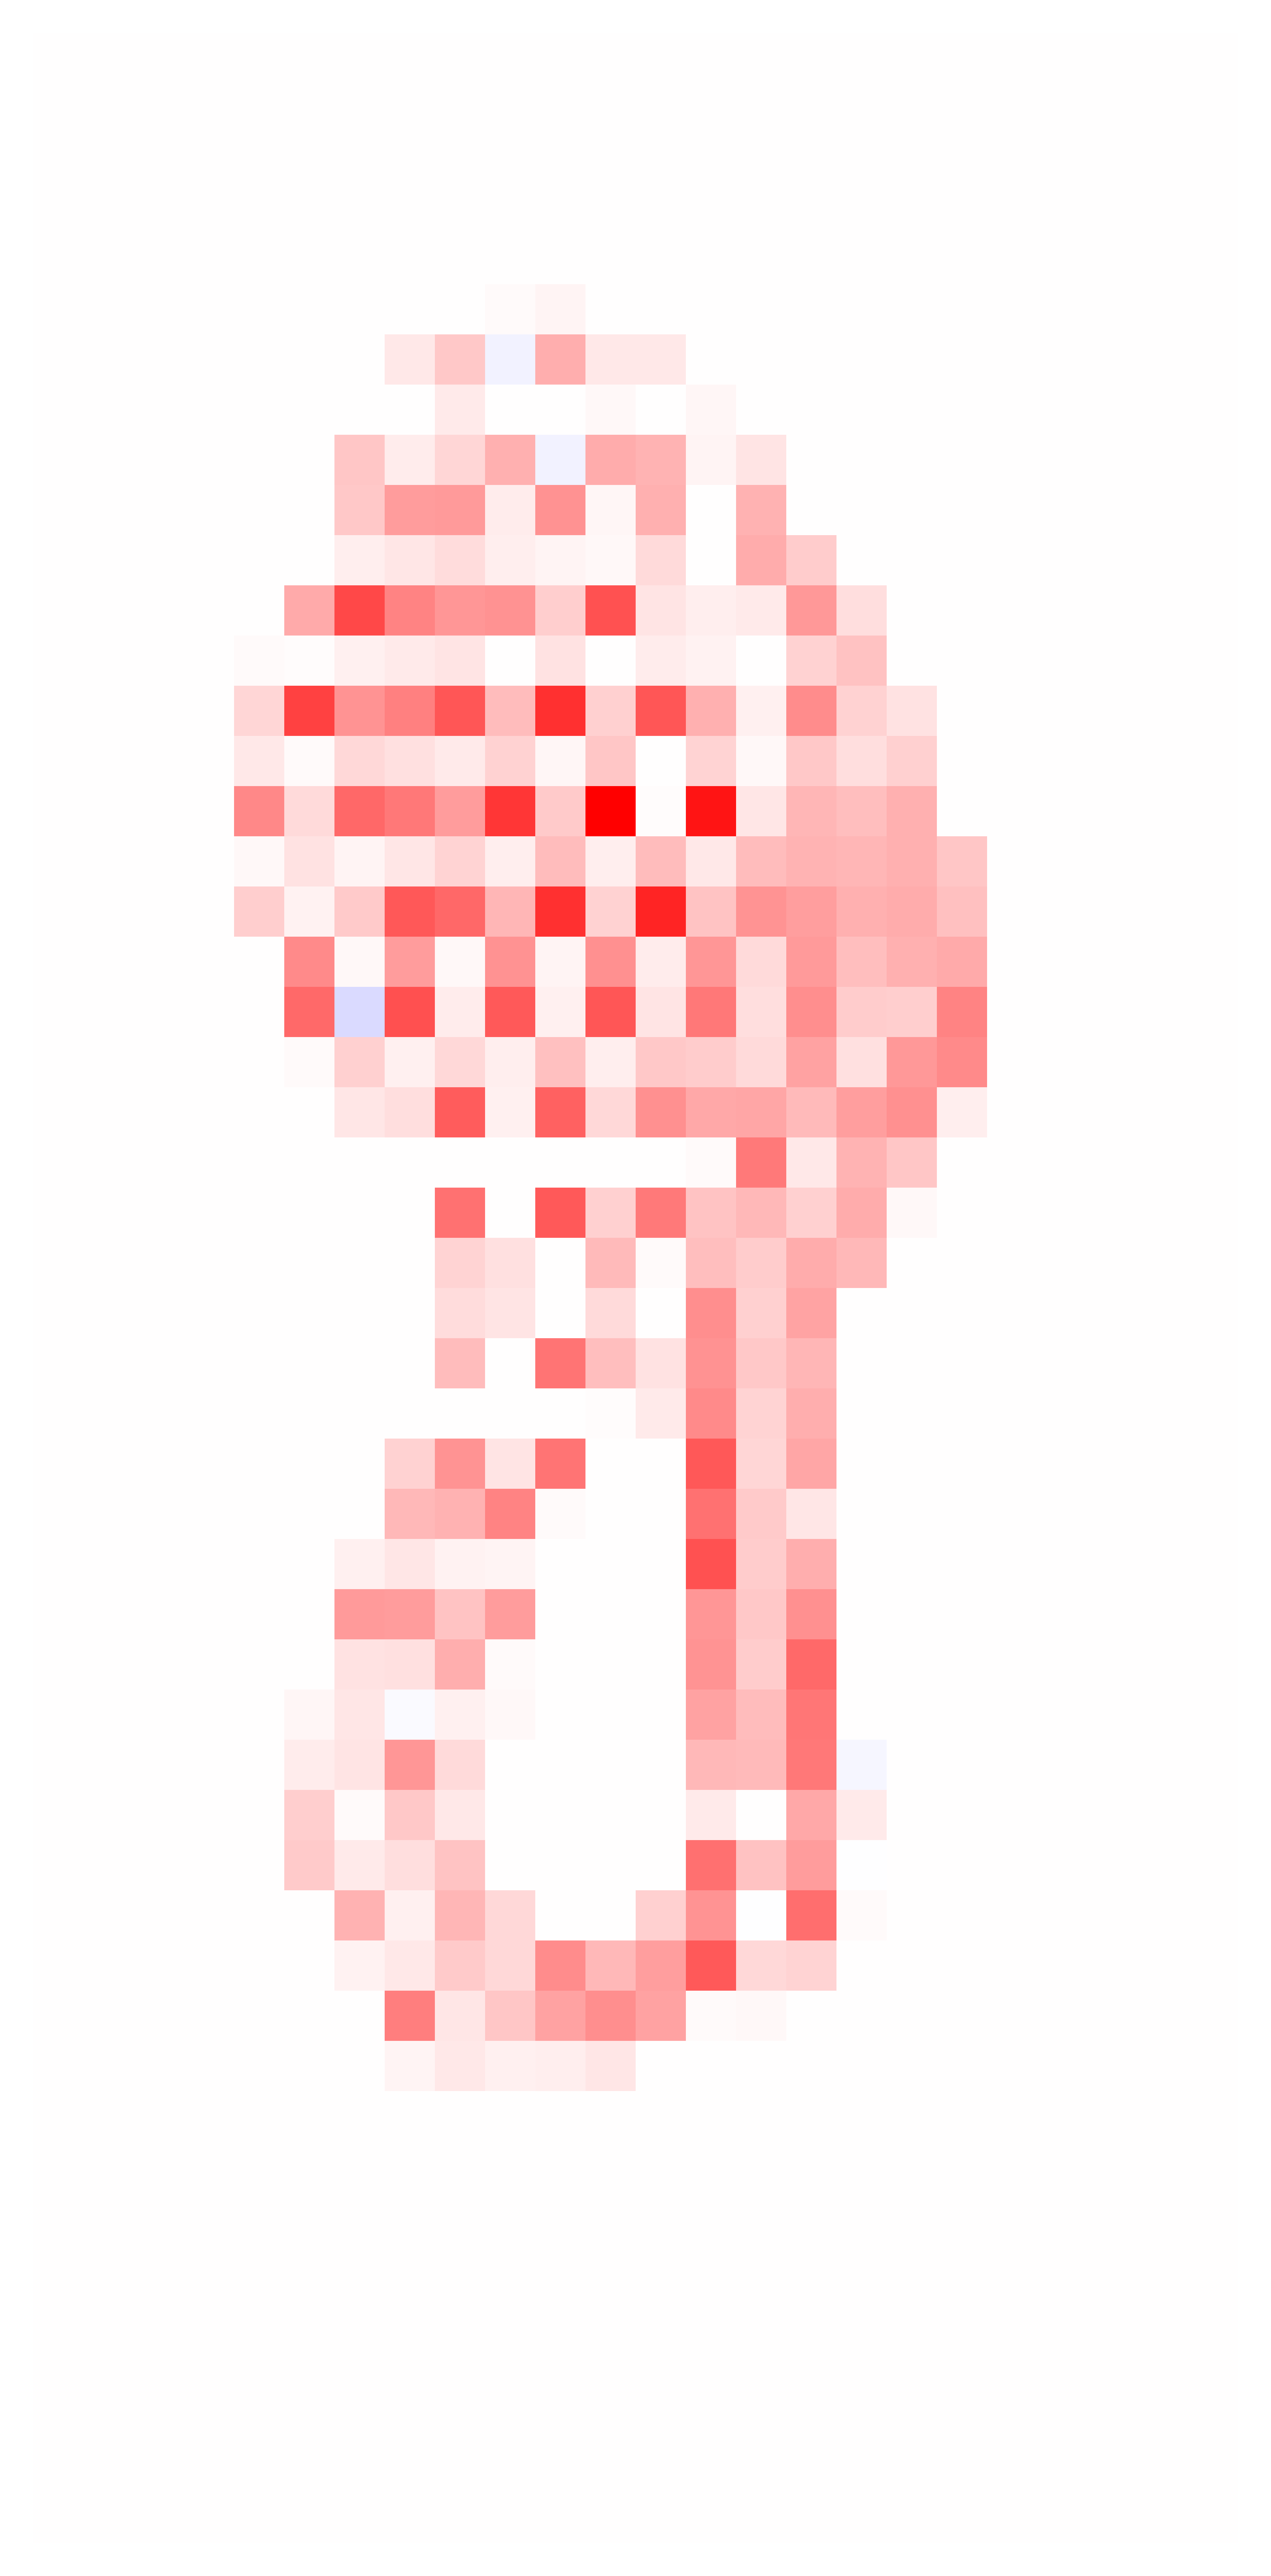

In [275]:
fig = plt.figure(figsize=(10, 10), dpi = 1000)
max_abs = np.max(np.abs(heat_matrix))
plt.axis('off')
plt.imshow(heat_matrix, cmap = 'bwr', interpolation = 'nearest', vmin = -max_abs, vmax = max_abs)
plt.savefig('Aligned Images/shoe01_M2_heatmap.png', 
            format='png', dpi=1000, bbox_inches='tight', pad_inches=0)

In [277]:
heatmap_img = Image.open('Aligned Images/shoe01_M2_heatmap.png')
heatmap_img = np.array(heatmap_img.resize((2196, 4530)))

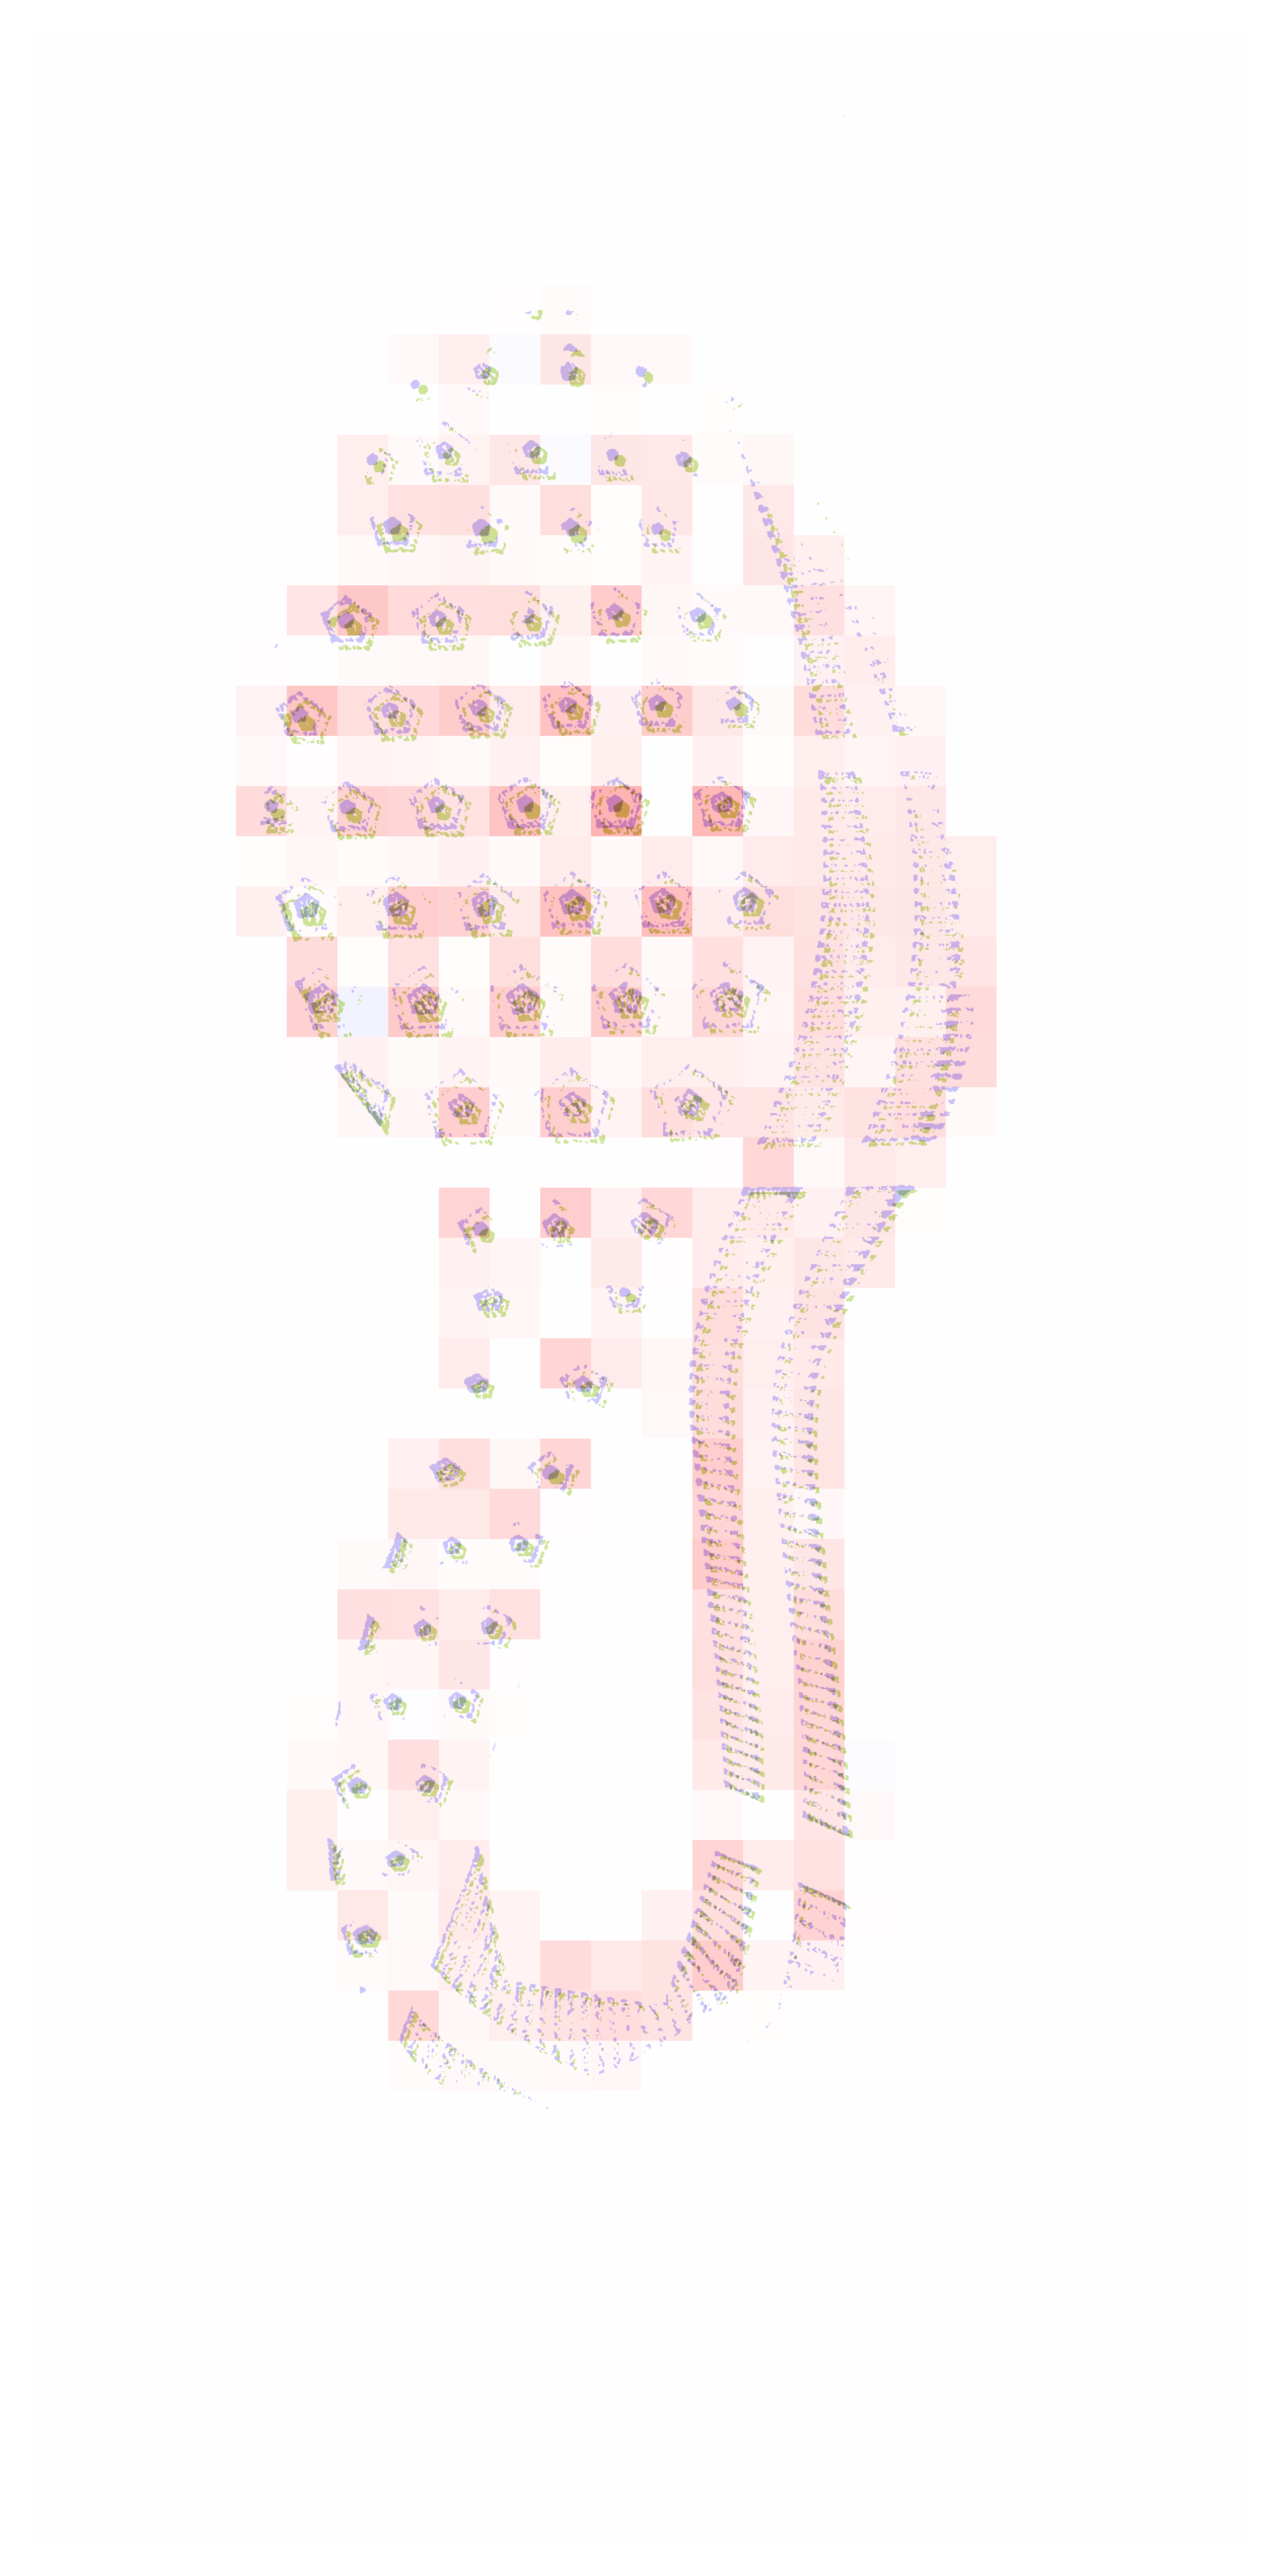

In [278]:
aligned_img = np.array(Image.open('Aligned Images/shoe01_M2_150v211.png'))

fig = plt.figure(figsize=(10, 10), dpi = 1000)
plt.imshow(aligned_img)
plt.imshow(heatmap_img, alpha = 0.3)
plt.axis('off')
plt.savefig('Aligned Images/shoe01_M2_150v211_heatmap.png', 
            format='png', dpi=1500, bbox_inches='tight', pad_inches=0)